In [1]:
import pandas as pd
import numpy as np
import ta
import tpqoa
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
#Metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
#Other
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
plt.style.use("seaborn")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
data = pd.read_csv("DNN_Data_2017_2021_MIN.csv", parse_dates = ["time"], index_col = "time")

In [3]:
data

,o,h,l,c,volume,complete
time,,,,,,
2017-01-02 23:00:00,1.04711,1.04711,1.04683,1.04698,110,True
2017-01-02 23:01:00,1.04697,1.04730,1.04692,1.04707,46,True
2017-01-02 23:02:00,1.04706,1.04728,1.04691,1.04691,52,True
2017-01-02 23:03:00,1.04689,1.04694,1.04673,1.04692,34,True
2017-01-02 23:04:00,1.04695,1.04695,1.04665,1.04669,15,True
...,...,...,...,...,...,...
2021-12-30 23:55:00,1.13248,1.13248,1.13244,1.13244,3,True
2021-12-30 23:56:00,1.13242,1.13242,1.13231,1.13233,11,True
2021-12-30 23:57:00,1.13231,1.13232,1.13228,1.13232,5,True


In [4]:
data.drop(['o','h','l','volume','complete'],axis=1,inplace=True)
data.rename(columns={'c':'Close_Price'},inplace=True)
symbol = 'Close_Price' 

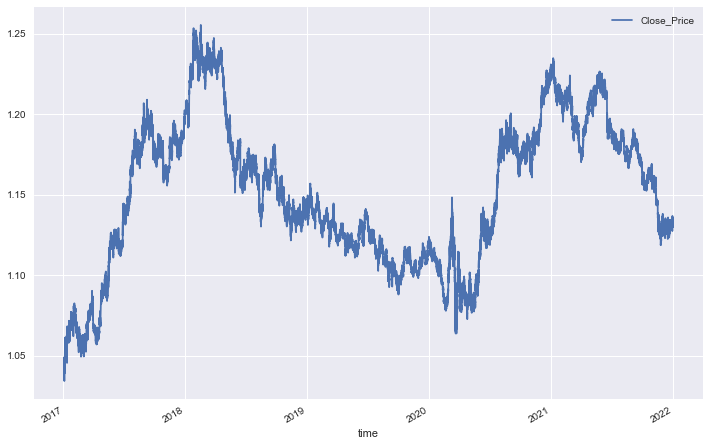

In [5]:
data.plot(figsize = (12, 8))
plt.show()

In [6]:
data["returns"] = np.log(data[symbol] / data[symbol].shift())

In [7]:
window = 50
df = data.copy()
df["dir"] = np.where(df["returns"] > 0, 1, -1)
df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(150).mean()
df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
df["mom"] = df["returns"].rolling(3).mean()
df["vol"] = df["returns"].rolling(window).std()
df.dropna(inplace = True)

In [8]:
df

,Close_Price,returns,dir,sma,boll,min,max,mom,vol
time,,,,,,,,,
2017-01-03 01:38:00,1.04807,0.00008,1,0.00070,1.55096,-0.00135,0.00000,0.00001,0.00011
2017-01-03 01:39:00,1.04808,0.00001,1,0.00071,1.50625,-0.00136,0.00000,0.00001,0.00011
2017-01-03 01:40:00,1.04815,0.00007,1,0.00073,1.59630,-0.00143,0.00000,0.00005,0.00011
2017-01-03 01:41:00,1.04812,-0.00003,-1,0.00074,1.45817,-0.00140,0.00003,0.00002,0.00010
2017-01-03 01:42:00,1.04814,0.00002,1,0.00076,1.43800,-0.00142,0.00001,0.00002,0.00010
...,...,...,...,...,...,...,...,...,...
2021-12-30 23:55:00,1.13244,-0.00002,-1,-0.00013,0.33169,-0.00035,0.00019,-0.00001,0.00006
2021-12-30 23:56:00,1.13233,-0.00010,-1,-0.00014,-0.23506,-0.00026,0.00028,-0.00004,0.00006
2021-12-30 23:57:00,1.13232,-0.00001,-1,-0.00014,-0.27696,-0.00025,0.00029,-0.00004,0.00006


In [9]:
lags = 5
cols = []
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]
for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)
df.dropna(inplace = True)

In [10]:
df

,Close_Price,returns,dir,sma,boll,min,max,mom,vol,dir_lag_1,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,
2017-01-03 01:44:00,1.04804,-0.00010,-1,0.00077,1.16232,-0.00133,0.00010,-0.00003,0.00011,1.00000,...,0.00002,0.00002,0.00005,0.00001,0.00001,0.00010,0.00010,0.00011,0.00011,0.00011
2017-01-03 01:45:00,1.04802,-0.00002,-1,0.00078,1.07248,-0.00131,0.00012,-0.00003,0.00010,-1.00000,...,-0.00003,0.00002,0.00002,0.00005,0.00001,0.00011,0.00010,0.00010,0.00011,0.00011
2017-01-03 01:46:00,1.04774,-0.00027,-1,0.00079,0.40697,-0.00104,0.00039,-0.00013,0.00010,-1.00000,...,-0.00003,-0.00003,0.00002,0.00002,0.00005,0.00010,0.00011,0.00010,0.00010,0.00011
2017-01-03 01:47:00,1.04763,-0.00010,-1,0.00080,0.11343,-0.00094,0.00050,-0.00013,0.00010,-1.00000,...,-0.00013,-0.00003,-0.00003,0.00002,0.00002,0.00010,0.00010,0.00011,0.00010,0.00010
2017-01-03 01:48:00,1.04758,-0.00005,-1,0.00081,-0.05590,-0.00086,0.00054,-0.00014,0.00010,-1.00000,...,-0.00013,-0.00013,-0.00003,-0.00003,0.00002,0.00010,0.00010,0.00010,0.00011,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 23:55:00,1.13244,-0.00002,-1,-0.00013,0.33169,-0.00035,0.00019,-0.00001,0.00006,-1.00000,...,0.00000,0.00003,0.00006,0.00012,0.00009,0.00007,0.00008,0.00008,0.00008,0.00008
2021-12-30 23:56:00,1.13233,-0.00010,-1,-0.00014,-0.23506,-0.00026,0.00028,-0.00004,0.00006,-1.00000,...,-0.00001,0.00000,0.00003,0.00006,0.00012,0.00006,0.00007,0.00008,0.00008,0.00008
2021-12-30 23:57:00,1.13232,-0.00001,-1,-0.00014,-0.27696,-0.00025,0.00029,-0.00004,0.00006,-1.00000,...,-0.00004,-0.00001,0.00000,0.00003,0.00006,0.00006,0.00006,0.00007,0.00008,0.00008


In [10]:
split = int(len(df)*0.66)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

In [10]:
#mu, std = train.mean(), train.std()
params = pickle.load(open("params.pkl", "rb"))
mu = params['mu']
std = params['std']

In [11]:
train_s = (train - mu) / std # standardization of train set features
#test_s = (test - mu) / std # standardization of test set features (with train set parameters!!!)
# X_train = train_s[cols]
# y_train = train['dir']
# X_test = test_s[cols]
# y_test = test['dir']

In [12]:
zeros = round(train['dir'].value_counts().loc[-1]/len(train) * 100,2)
ones = round(train['dir'].value_counts().loc[1]/len(train) * 100,2)
print(f'Percentage of Zeros {zeros} %')
print(f'Percentage of Ones {ones} %')

Percentage of Zeros 52.96 %
Percentage of Ones 47.04 %


In [15]:
RF_clf = RandomForestClassifier(random_state=1)
RF_clf.fit(X_train,y_train)

y_test_pred = RF_clf.predict(X_test)
confMatrixTest = confusion_matrix(y_test, y_test_pred, labels=None)
print ('RF: Macro Precision, recall, f1-score')
print ( precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print ('RF: Micro Precision, recall, f1-score')
print (precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print ('\n')

pickle.dump(RF_clf, open('Random_Forest_3.sav', 'wb'))

RF: Macro Precision, recall, f1-score
(0.5086449699945303, 0.5074568116459959, 0.49493564680944724, None)
RF: Micro Precision, recall, f1-score
(0.5190854771784232, 0.5190854771784232, 0.5190854771784232, None)




In [27]:
#LR_clf = LogisticRegression(random_state=1)
#LR_clf.fit(X_train,y_train)
RF = pickle.load(open('Random_Forest_3.sav', "rb"))
y_test_pred = RF.predict(X_test)
confMatrixTest = confusion_matrix(y_test, y_test_pred, labels=None)
print ('RF: Macro Precision, recall, f1-score')
print ( precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print ('RF: Micro Precision, recall, f1-score')
print (precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print ('\n')

pickle.dump(LR_clf, open('Logistic_Regression_model.sav', 'wb'))

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: Macro Precision, recall, f1-score
(0.5171524305130362, 0.5066752322054368, 0.42914392571267085, None)
RF: Micro Precision, recall, f1-score
(0.5309626556016598, 0.5309626556016598, 0.5309626556016598, None)




In [13]:
LR_clf = LogisticRegression(C = 1e6 , max_iter = 100000, multi_class = 'ovr')
LR_clf.fit(X_train,y_train)

y_test_pred = LR_clf.predict(X_test)
confMatrixTest = confusion_matrix(y_test, y_test_pred, labels=None)
print ('RF: Macro Precision, recall, f1-score')
print ( precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print ('RF: Micro Precision, recall, f1-score')
print (precision_recall_fscore_support(y_test, y_test_pred, average='micro'))
print ('\n')

pickle.dump(LR_clf, open('Logistic_Regression_model2.sav', 'wb'))

RF: Macro Precision, recall, f1-score
(0.5172613867210444, 0.5067115123958951, 0.4291302029969093, None)
RF: Micro Precision, recall, f1-score
(0.5310058091286307, 0.5310058091286307, 0.5310058091286307, None)




In [16]:
X_test['pred'] = y_test_pred

C:\Users\Panos2\AppData\Local\Temp\ipykernel_1528\2208443455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = y_test_pred


In [17]:
X_test

,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,...,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5,pred
time,,,,,,,,,,,,,,,,,,,,,
2020-05-04 13:27:00,-0.94253,-0.94253,-0.94253,1.06097,-0.94253,-0.27824,-0.24047,-0.21705,-0.19247,-0.16873,...,-1.14333,-1.94714,-2.28527,-2.87753,0.14519,0.18889,0.21117,0.19469,0.19226,1
2020-05-04 13:28:00,1.06097,-0.94253,-0.94253,-0.94253,1.06097,-0.30420,-0.27825,-0.24047,-0.21705,-0.19247,...,-2.32873,-1.14334,-1.94714,-2.28528,0.28606,0.14519,0.18889,0.21117,0.19469,-1
2020-05-04 13:29:00,1.06097,1.06097,-0.94253,-0.94253,-0.94253,-0.33237,-0.30420,-0.27825,-0.24047,-0.21705,...,-0.16981,-2.32874,-1.14334,-1.94715,0.29201,0.28606,0.14519,0.18889,0.21117,-1
2020-05-04 13:30:00,-0.94253,1.06097,1.06097,-0.94253,-0.94253,-0.35801,-0.33237,-0.30420,-0.27825,-0.24048,...,1.01537,-0.16981,-2.32874,-1.14335,0.28188,0.29201,0.28606,0.14519,0.18889,1
2020-05-04 13:31:00,-0.94253,-0.94253,1.06097,1.06097,-0.94253,-0.37574,-0.35801,-0.33237,-0.30420,-0.27825,...,1.52357,1.01537,-0.16981,-2.32875,0.23361,0.28188,0.29201,0.28606,0.14519,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 23:55:00,-0.94253,-0.94253,1.06097,1.06097,1.06097,-0.20797,-0.19046,-0.18128,-0.17158,-0.15987,...,0.40793,0.81637,1.67428,1.30670,-0.58456,-0.46981,-0.46826,-0.45950,-0.46231,-1
2021-12-30 23:56:00,-0.94253,-0.94253,-0.94253,1.06097,1.06097,-0.21663,-0.20798,-0.19046,-0.18128,-0.17158,...,0.04035,0.40792,0.81637,1.67428,-0.72028,-0.58456,-0.46981,-0.46826,-0.45950,-1
2021-12-30 23:57:00,-0.94253,-0.94253,-0.94253,-0.94253,1.06097,-0.22317,-0.21663,-0.20798,-0.19046,-0.18128,...,-0.16386,0.04034,0.40792,0.81637,-0.72943,-0.72028,-0.58456,-0.46981,-0.46826,-1
